In [13]:
#######################################################################################################
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import sys

# Get the current notebook's directory
notebook_dir = os.path.abspath('')
# Add the relative path to your Codes directory
codes_path = os.path.join(notebook_dir, "..", "Codes")
codes_path = os.path.abspath(codes_path)  # Normalize the path
# Add to path if not already there
if codes_path not in sys.path:
    sys.path.insert(1, codes_path)
from myUtils import *

In [14]:
codes_path

'/home/emanuele/Research/APES/Forest_Human_Nexus/Codes'

# 1. Read shapefiles

In [15]:
# World shapefile
shapef = os.path.join(MAINPATH, 'Data/SHAPEFILES/world-administrative-boundaries.shp')
gdf = gpd.read_file(shapef)
gdf = gdf.to_crs("ESRI:54009")

# Custom regions shapefiles 
shapef = os.path.join(MAINPATH, 'Data/SHAPEFILES/world-custom_regions_r.shp')
gdf1 = gpd.read_file(shapef)
gdf1 = gdf1.to_crs("ESRI:54009")

# 2. Define data

In [108]:
PATHL = os.path.join(MAINPATH, 'Data/OUTPUT/FA/FA_{window}_{year}.tif')
dfData = return_df(PATHL, gdf1) 


PATHL = os.path.join(MAINPATH, 'Data/OUTPUT/POP/POP_{window}_{year}.tif')
dfData1 = return_df(PATHL, gdf1) 

RasterioIOError: /home/emanuele/Research/APES/FHN/Data/OUTPUT/FA/FA_50_1975.tif: No such file or directory

### 2.1 2020

In [102]:
dfData2020 = dfData[dfData['year']==2020].reset_index(drop=True)
dfData20201 = dfData1[dfData1['year']==2020].reset_index(drop=True)
dfData2020['population'] = dfData20201['sum']
dfData2020['FAP'] = dfData2020['sum'] / dfData2020['population']

In [107]:
dfData2020['sum'].sum()

1567997.8

In [103]:
dfData2020 = dfData2020.sort_values(by='FAP').reset_index(drop=True)
colors = dfData2020['region'].map(REGION_TO_CONTINENT).map(CONTINENT_COLORS)
dfData2020['FAP'] = dfData2020['FAP']*100 ## from km2 to ha

### Figure 1C

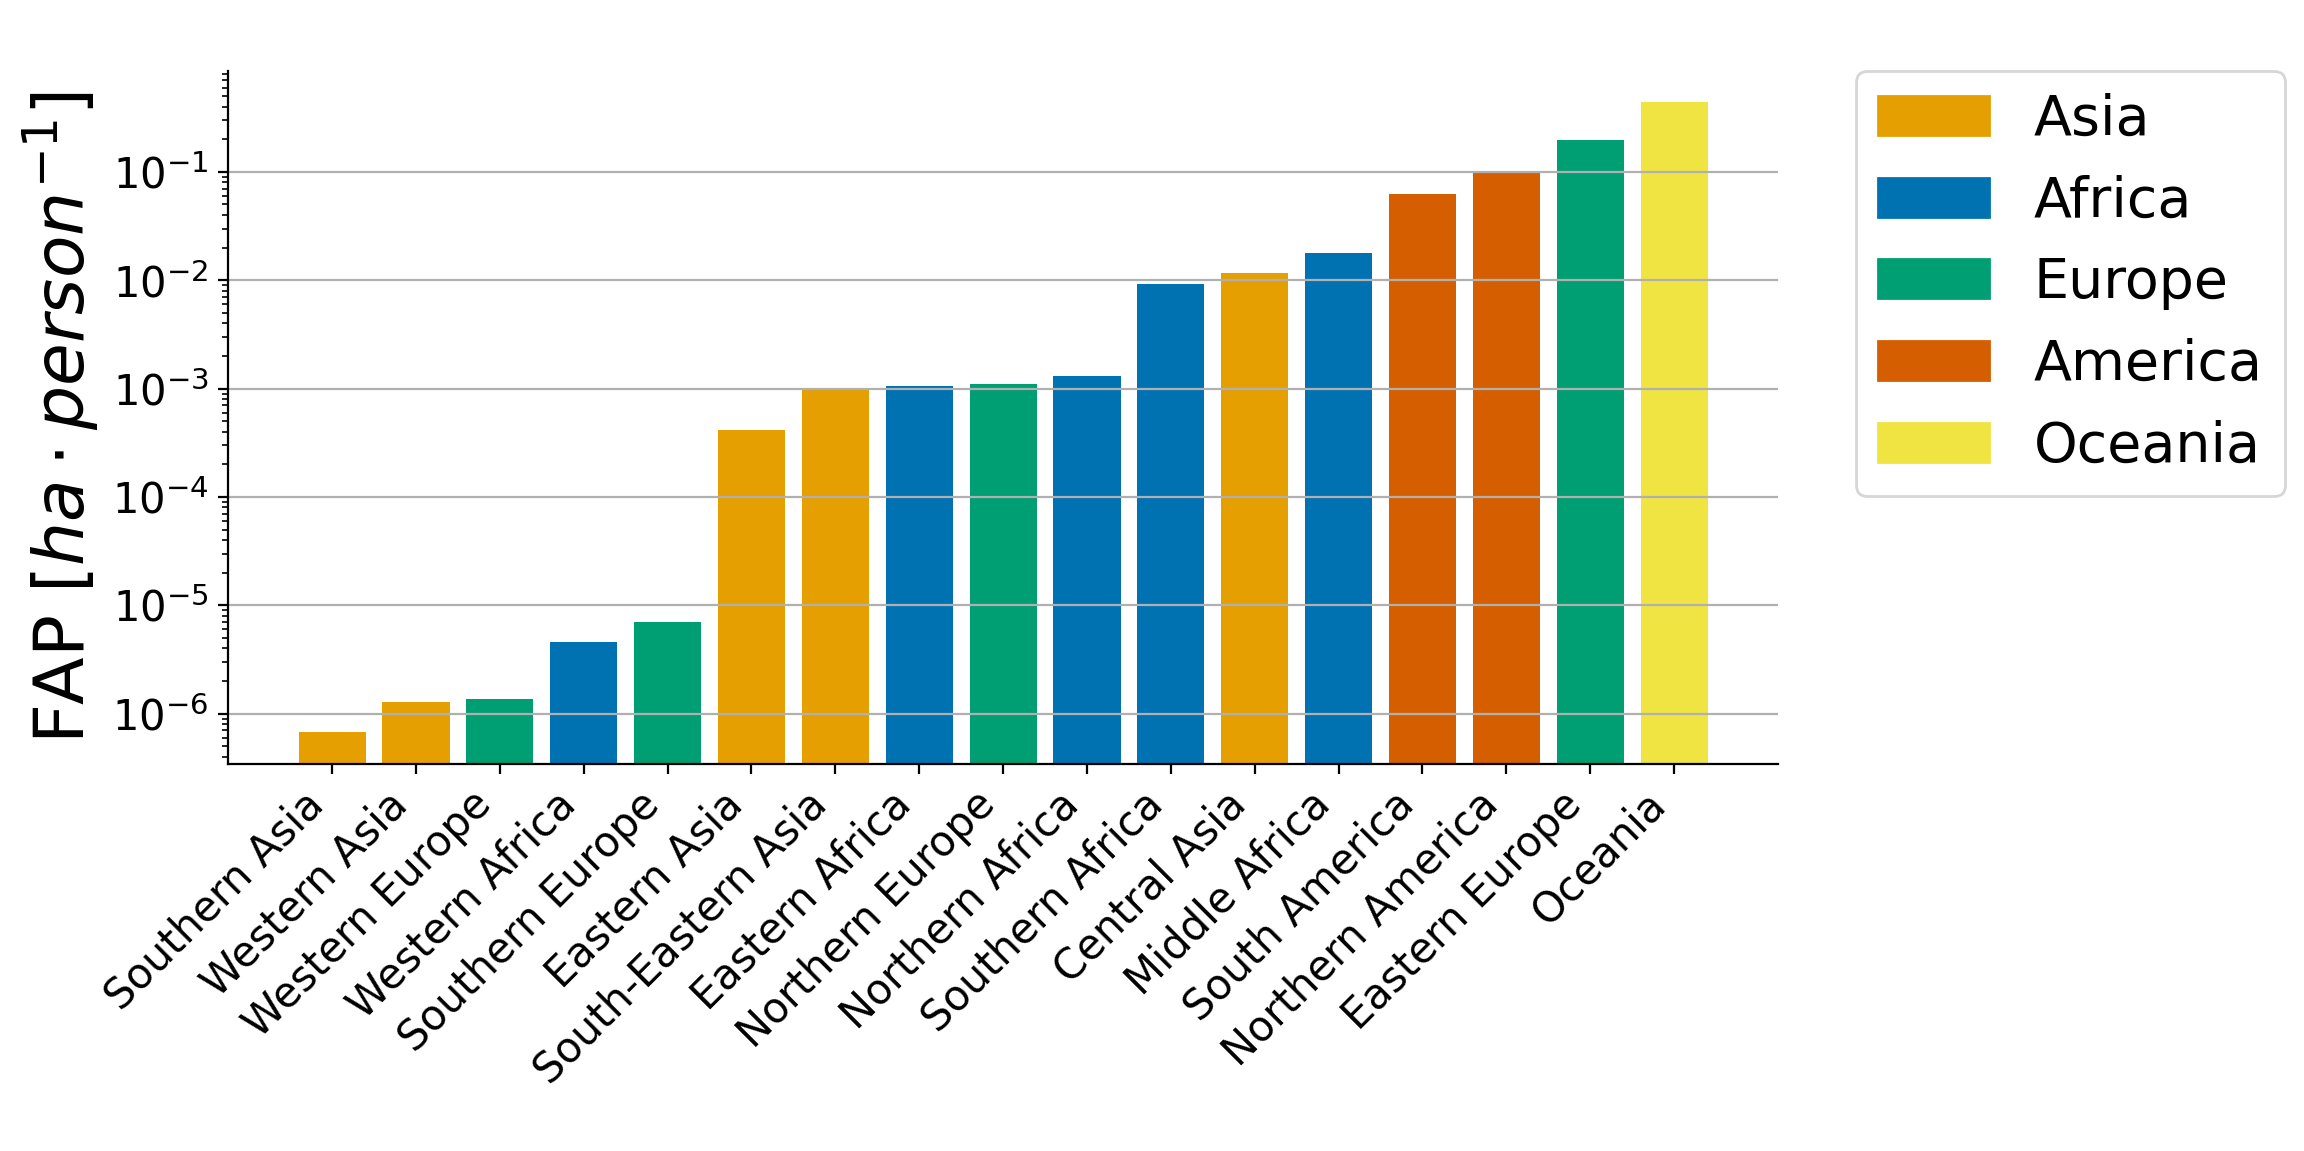

In [104]:
# Plotting the bar plot
f, ax = plt.subplots(figsize=(10, 4.5))
ax = set_font(ax, 15)
plt.bar(dfData2020['region'], c, color=colors)
# Adding labels and title
plt.xlabel(' ')
plt.ylabel('FAP '+r'$[ha \cdot person^{-1}]$', size=25)
plt.title(' ', size=16)
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Creating legend patches
patches = [mpatches.Patch(color=color, label=continent) for continent, color in CONTINENT_COLORS.items()]
# Adding the legend outside the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20)
plt.xticks(rotation=45, ha='right');
ax.set_yscale('log')

In [58]:
# Save Figure 1C
fout = '../Figures/Figure1C.pdf'
f.savefig(fout, dpi=300, bbox_inches='tight')

### 2.2 Relative change

In [60]:
dfData['population'] = dfData1['sum']
dfData['FAP'] = dfData['sum'] / dfData['population']

In [61]:
dfData_= rel_change_df(dfData, 'FAP')
df5_ = dfData_.sort_values(by='relative_change').reset_index(drop=True)
colors = df5_['region'].map(REGION_TO_CONTINENT).map(CONTINENT_COLORS)

### Figure 1D

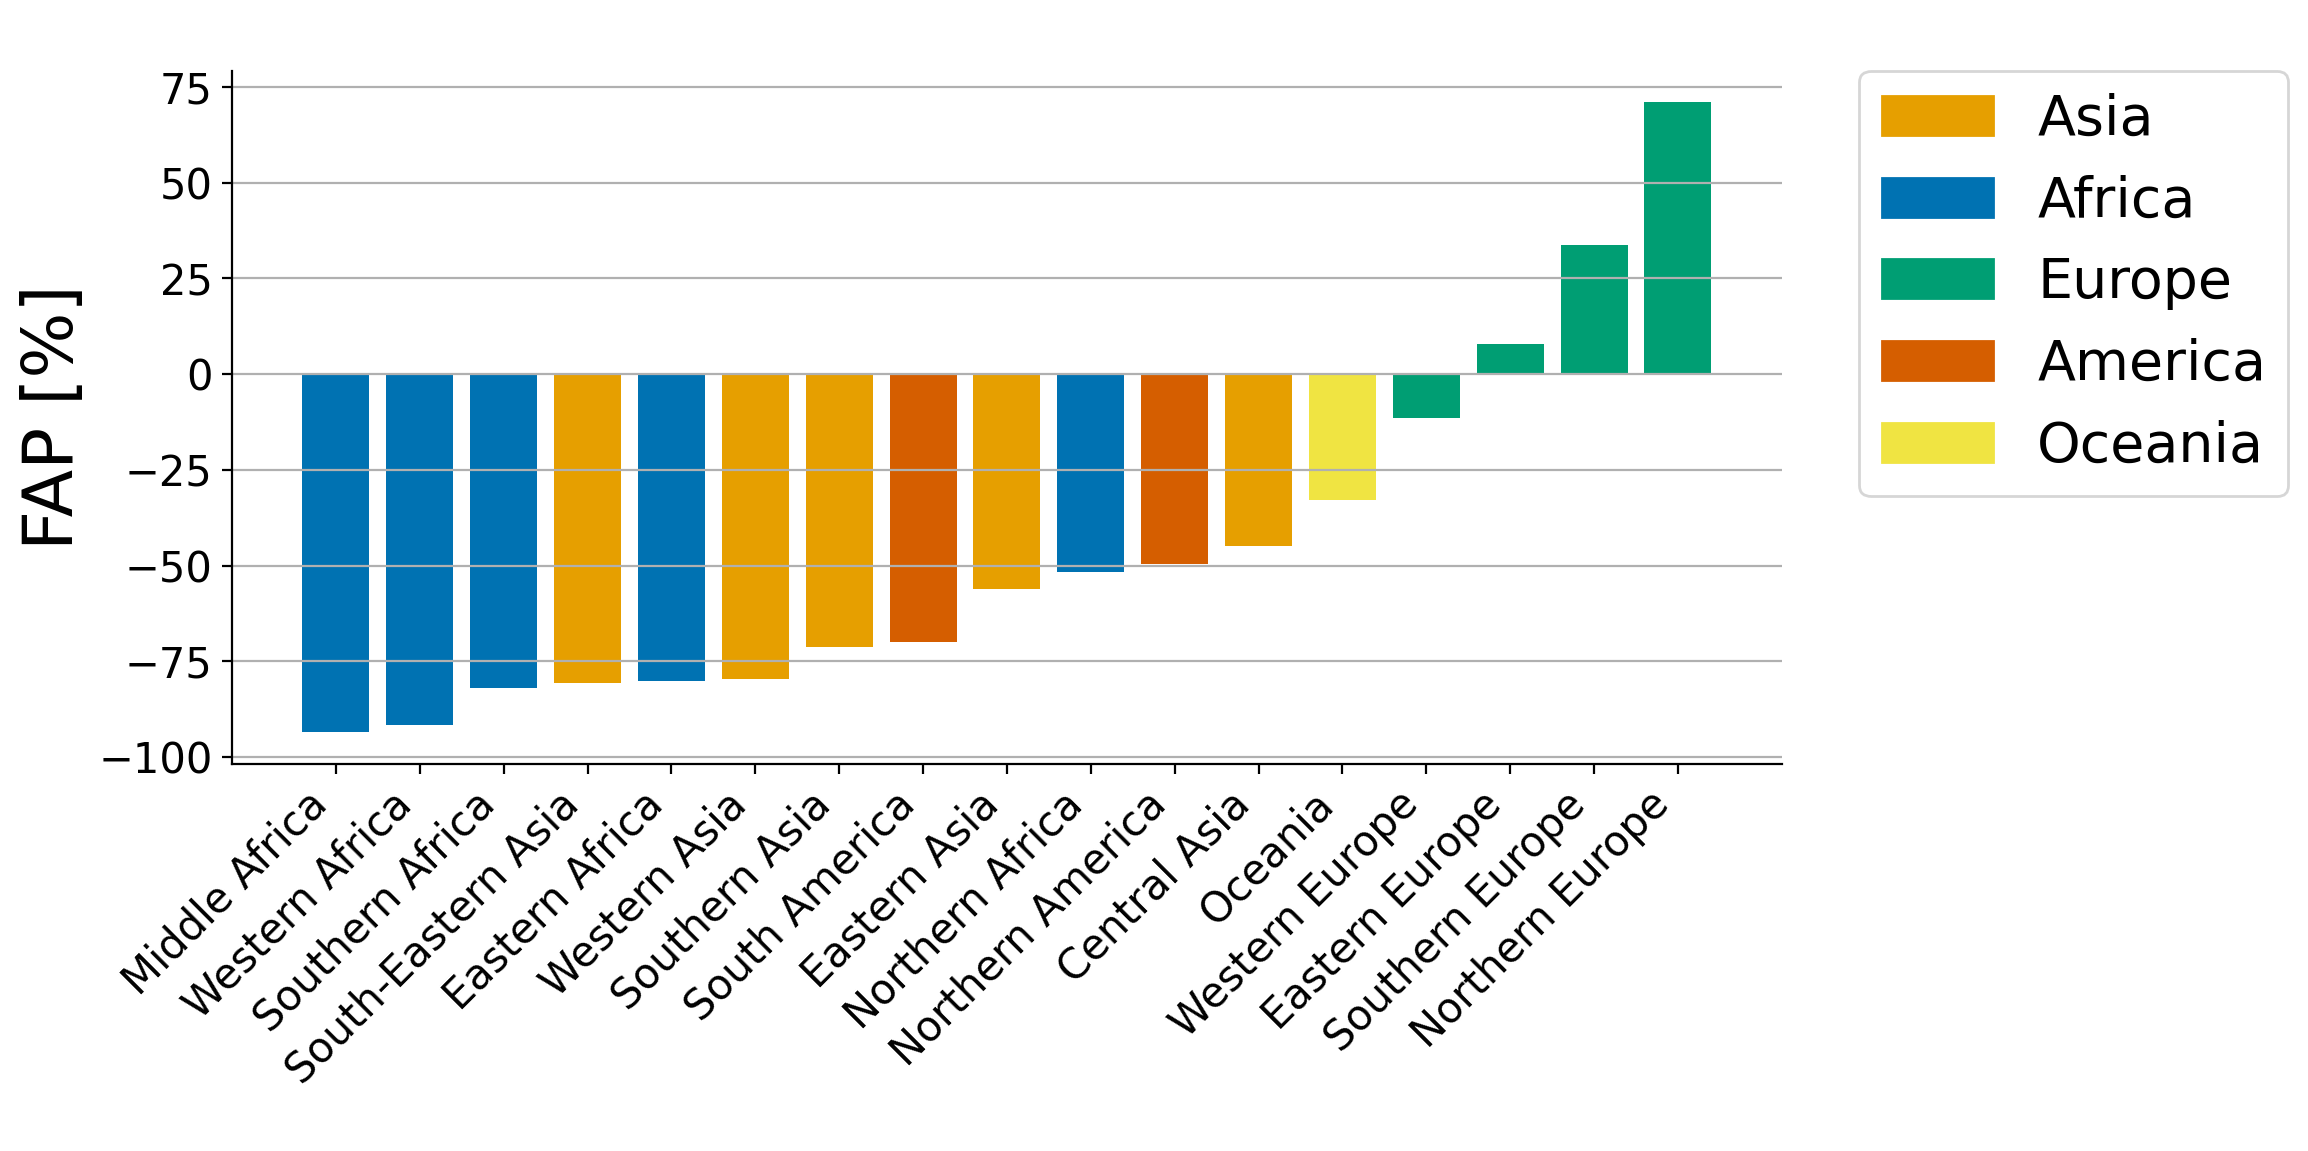

In [62]:
# Plotting the bar plot
f, ax = plt.subplots(figsize=(10, 4.5))
ax = set_font(ax, 15)
plt.bar(df5_['region'], df5_['relative_change'], color=colors)
# Adding labels and title
plt.xlabel(' ')
plt.ylabel('FAP [%]', size=25)
plt.title(' ', size=16)
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Creating legend patches
patches = [mpatches.Patch(color=color, label=continent) for continent, color in CONTINENT_COLORS.items()]
# Adding the legend outside the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20)
plt.xticks(rotation=45, ha='right');

In [63]:
# Save Figure 1D
fout = '../Figures/Figure1D.pdf'
f.savefig(fout, dpi=300, bbox_inches='tight')

In [100]:
def detect_turning_points(years, values, slope_threshold=0.5):
    """
    Detect turning points in a time series where the slope changes significantly.
    
    Parameters:
    - years: array of years (x-values)
    - values: array of measurements (y-values)
    - slope_threshold: minimum absolute difference in slopes to consider a turning point
    
    Returns:
    - turning_points: indices of detected turning points
    - turning_years: years where turning points occur
    - turning_values: values at turning points
    """
    # Calculate time intervals
    time_intervals = np.diff(years)
    
    # Calculate slopes between consecutive points
    slopes = np.diff(values) / time_intervals
    
    turning_points = []
    # Start from the second point and end at the second-to-last point
    for i in range(1, len(slopes)):
        # Calculate slope difference
        slope_diff = slopes[i] - slopes[i-1]
        
        # Check for sign change
        sign_change = (slopes[i-1] > 0 and slopes[i] < 0) or (slopes[i-1] < 0 and slopes[i] > 0)
        
        # Handle the case where one slope is exactly zero
        if slopes[i-1] == 0 or slopes[i] == 0:
            sign_change = True
        
        # Check if slope exceeds threshold and changes sign
        if sign_change and (abs(slope_diff) > slope_threshold):
            # The turning point is at index i in the original series
            turning_points.append(i)
    
    turning_years = years[turning_points]
    turning_values = values[turning_points]
    
    return turning_points, turning_years, turning_values

In [78]:
REGIONS = dfData['region'].unique()

In [70]:
df_FAP_all = dfData[['year', 'region', 'FAP']]
col_to_plot = 'FAP'
new_col = col_to_plot+'_rel'
df_FAP_all[new_col] = 0
for region in REGIONS:
    # Get indices and sorted data for this region
    region_indices = df_FAP_all[df_FAP_all["region"] == region].index
    df_region = df_FAP_all[df_FAP_all["region"] == region].sort_values("year").reset_index(drop=True)
    
    if len(df_region) > 0:  # Add safety check
        # Calculate relative change
        signal = df_region[col_to_plot].values
        baseline = signal[0]
        if baseline != 0:  # Add safety check for division by zero
            signal = 100 * (signal - baseline) / baseline
            # Update values in original DataFrame
            df_FAP_all.loc[region_indices, new_col] = signal

In [73]:
# Define the fixed number of rows (continents)
continent_order = ["Africa", "Asia", "America", "Oceania", "Europe"]
rows = len(continent_order)

In [74]:
df_FAP_all["Continent"] = df_FAP_all["region"].map(REGION_TO_CONTINENT)
# Get unique regions per continent
regions_by_continent = {continent: df_FAP_all[df_FAP_all["Continent"] == continent]["region"].unique() \
                        for continent in continent_order}
# Determine the maximum number of columns based on the continent with the most regions
cols = max(len(regions) for regions in regions_by_continent.values())

In [88]:
col_to_plot = 'FAP_rel'

Eastern Africa: found 0 turning points
Middle Africa: found 1 turning points
Northern Africa: found 1 turning points
Southern Africa: found 1 turning points
Western Africa: found 0 turning points
Central Asia: found 3 turning points
Eastern Asia: found 3 turning points
South-Eastern Asia: found 0 turning points
Southern Asia: found 0 turning points
Western Asia: found 0 turning points
Northern America: found 1 turning points
South America: found 1 turning points
Oceania: found 3 turning points
Eastern Europe: found 1 turning points
Northern Europe: found 4 turning points
Southern Europe: found 2 turning points
Western Europe: found 0 turning points


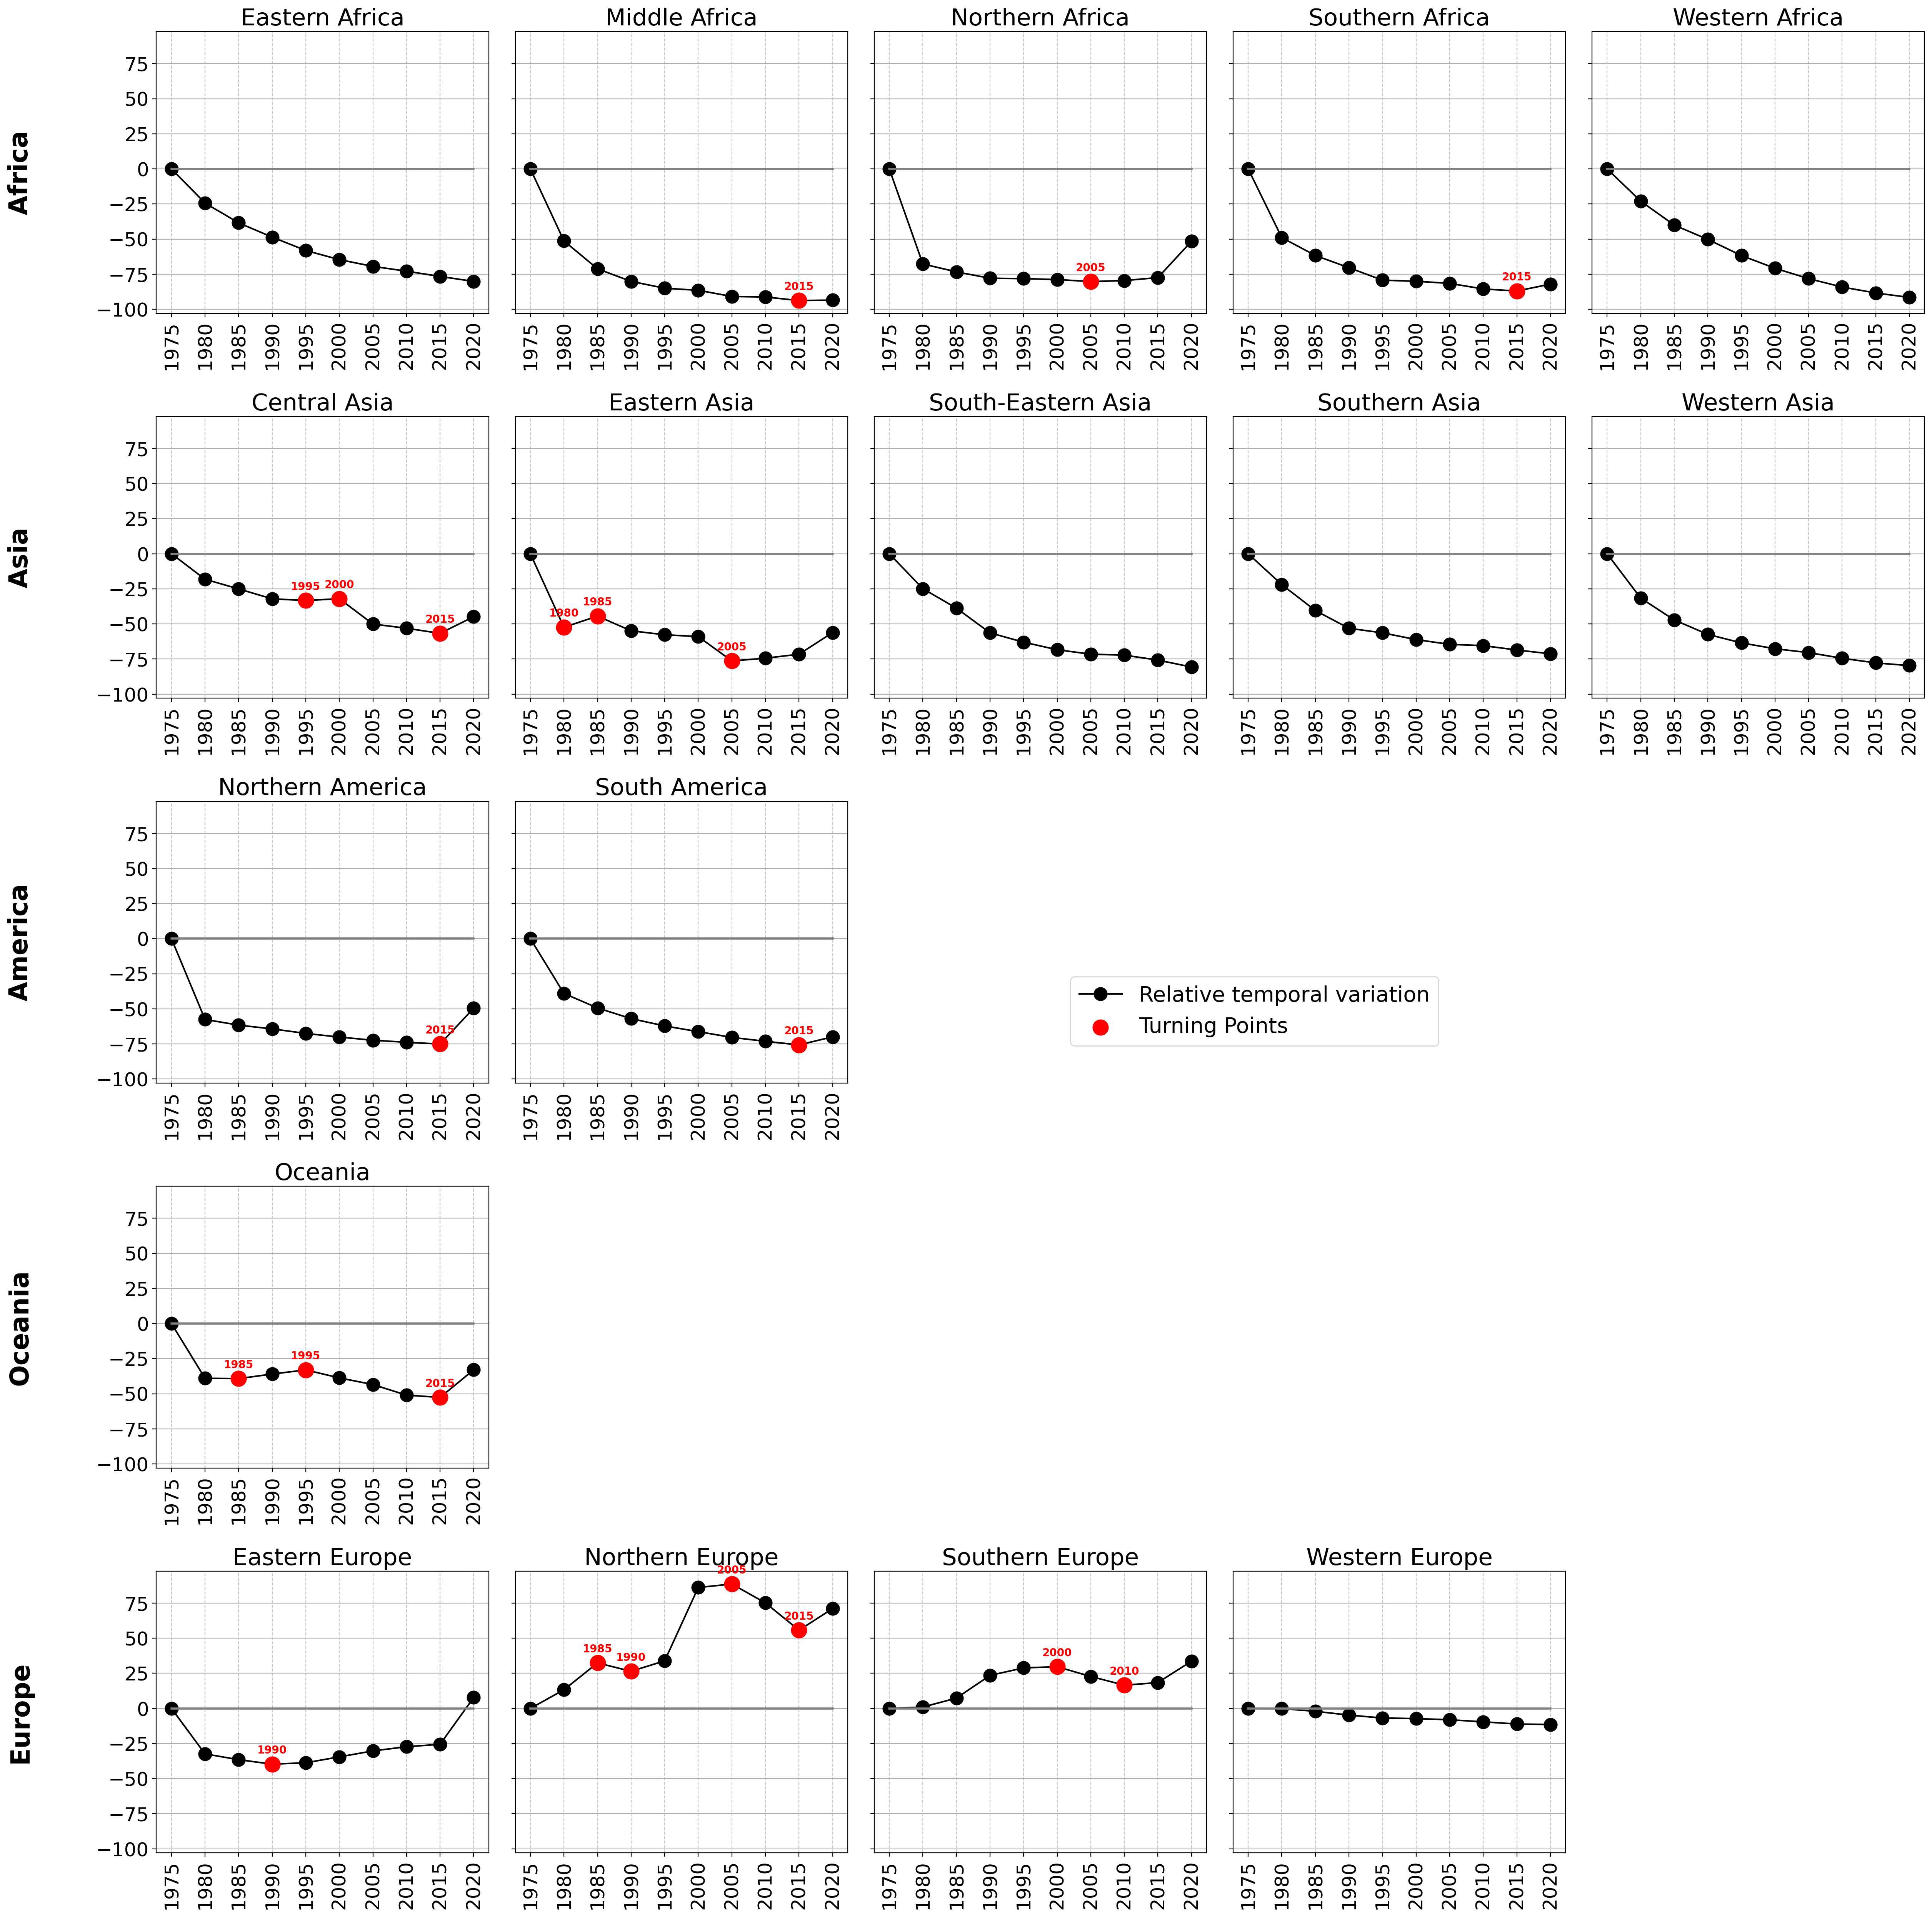

In [101]:
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), 
                         constrained_layout=True, sharex=False, sharey=True)
# Ensure axes is a 2D array
if rows == 1:
    axes = np.expand_dims(axes, axis=0)
if cols == 1:
    axes = np.expand_dims(axes, axis=1)
    
# Dictionary to store unique legend handles and labels
unique_handles = {}    

# Iterate over continents and regions to populate the subplots
for row_idx, continent in enumerate(continent_order):
    regions = regions_by_continent[continent]
    for col_idx, region in enumerate(regions):
        ax = axes[row_idx, col_idx]  # Get the corresponding subplot
        ax = set_font(ax, 18)
        
        # Get data for this region
        df_region = df_FAP_all[df_FAP_all["region"] == region].sort_values("year").reset_index(drop=True)
        
        # Calculate turning points
        slope_threshold = 0.1  # Adjust as needed
        years = df_region['year'].values
        values = df_region[col_to_plot].values
        
        indices, turning_years, turning_values = detect_turning_points(years, values, slope_threshold)
        print(f"{region}: found {len(turning_years)} turning points")
        
        # Plot the main line
        line1, = ax.plot(df_region["year"], df_region[col_to_plot], marker="o", 
                         markersize=12, color="black", label="Relative temporal variation")
        # Plot the zero reference line
        line2, = ax.plot([1975, 2020], [0, 0], lw=2, color='gray')
        
        # Plot turning points with higher z-order to ensure visibility
        if len(turning_years) > 0:
            tp_scatter = ax.scatter(turning_years, turning_values, color='red', 
                                   s=200, zorder=10, label='Turning Points')
            unique_handles['Turning Points'] = tp_scatter
            
            # Optional: Add text labels for turning points
            for year, value in zip(turning_years, turning_values):
                ax.annotate(f"{year}", (year, value), xytext=(0, 10), 
                           textcoords='offset points', ha='center', color='red', fontweight='bold')
        
        # Store handles for legend
        unique_handles['Relative temporal variation'] = line1
        
        # Set labels and title
        ax.set_xlabel(" ")
        ax.set_ylabel(" ")
        ax.set_title(region, size=22)
        ax.grid(True)
        
    # Hide unused subplots in this row
    for col_idx in range(len(regions), cols):
        fig.delaxes(axes[row_idx, col_idx])

# Set row labels (continent names)
for row_idx, continent in enumerate(continent_order):
    ax = axes[row_idx, 0]
    ax.set_ylabel(f"{continent}\n\n ", fontsize=24, fontweight="bold")

# Place the legend outside the plot
fig.legend(unique_handles.values(), unique_handles.keys(),
           bbox_to_anchor=(0.65, 0.5),  # Adjust position as needed
           loc='upper center', ncol=len(unique_handles)-1, fontsize=20)

# Set x-axis ticks
all_years = np.arange(1975, 2021, 5)
for ax in axes.flatten():
    if ax.get_subplotspec().get_geometry()[2] < rows * cols:  # Check if not deleted
        ax.set_xticks(all_years)
        ax.set_xticklabels(all_years, rotation=90)
        ax.grid(True, which="major", axis="x", linestyle="--", alpha=0.7)

plt.show()

In [92]:
import pymannkendall as mk  # Use pymannkendall for Sen's slope and Mann-Kendall test
import seaborn as sns
from scipy import stats
results_list = []
# For each region, plot data and calculate Sen's slope
for i, region in enumerate(REGIONS):
    df_region = df_FAP_all[df_FAP_all["region"] == region].sort_values("year")
    
    # Extract x and y data
    x = df_region['year'].values
    y = df_region[col_to_plot].values
    
    # Plot the original data
    
    # Run Mann-Kendall test and Sen's slope analysis
    mk_result = mk.original_test(y, alpha=0.05)
    
    # Get the slope
    slope = mk_result.slope

    # Calculate the trend line using Sen's slope
    y_start = mk_result.intercept + mk_result.slope * x[0]
    y_end = mk_result.intercept + mk_result.slope * x[-1]

    # Get significance stars
    significance = ''
    if mk_result.p < 0.001:
        significance = '***'
    elif mk_result.p < 0.01:
        significance = '**'
    elif mk_result.p < 0.05:
        significance = '*'
    else:
        significance = 'ns'
    
    # Add results to list
    results_list.append({
        'Region': region,
        'Slope': slope,
        'p-value': mk_result.p,
        'Significance': significance,
        'Trend': mk_result.trend,
        'Intercept': mk_result.intercept
    })

# Create a results dataframe
results_df = pd.DataFrame(results_list)

In [93]:
results_df

,Region,Slope,p-value,Significance,Trend,Intercept
0,Central Asia,-5.507012,0.002358,**,decreasing,-7.920778
1,Eastern Africa,-6.973830,0.000083,***,decreasing,-30.010536
2,Eastern Asia,-4.182503,0.020045,*,decreasing,-38.093843
3,Eastern Europe,1.822183,0.152406,ns,no trend,-39.524020
4,Middle Africa,-4.388916,0.000172,***,decreasing,-66.009995
5,Northern Africa,-1.034164,0.152406,ns,no trend,-73.019058
6,Northern America,-2.574814,0.012266,*,decreasing,-54.306713
7,Northern Europe,7.456713,0.020045,*,increasing,11.251885
8,Oceania,-2.232269,0.210498,ns,no trend,-28.807346
9,South America,-4.642035,0.000677,***,decreasing,-43.320655


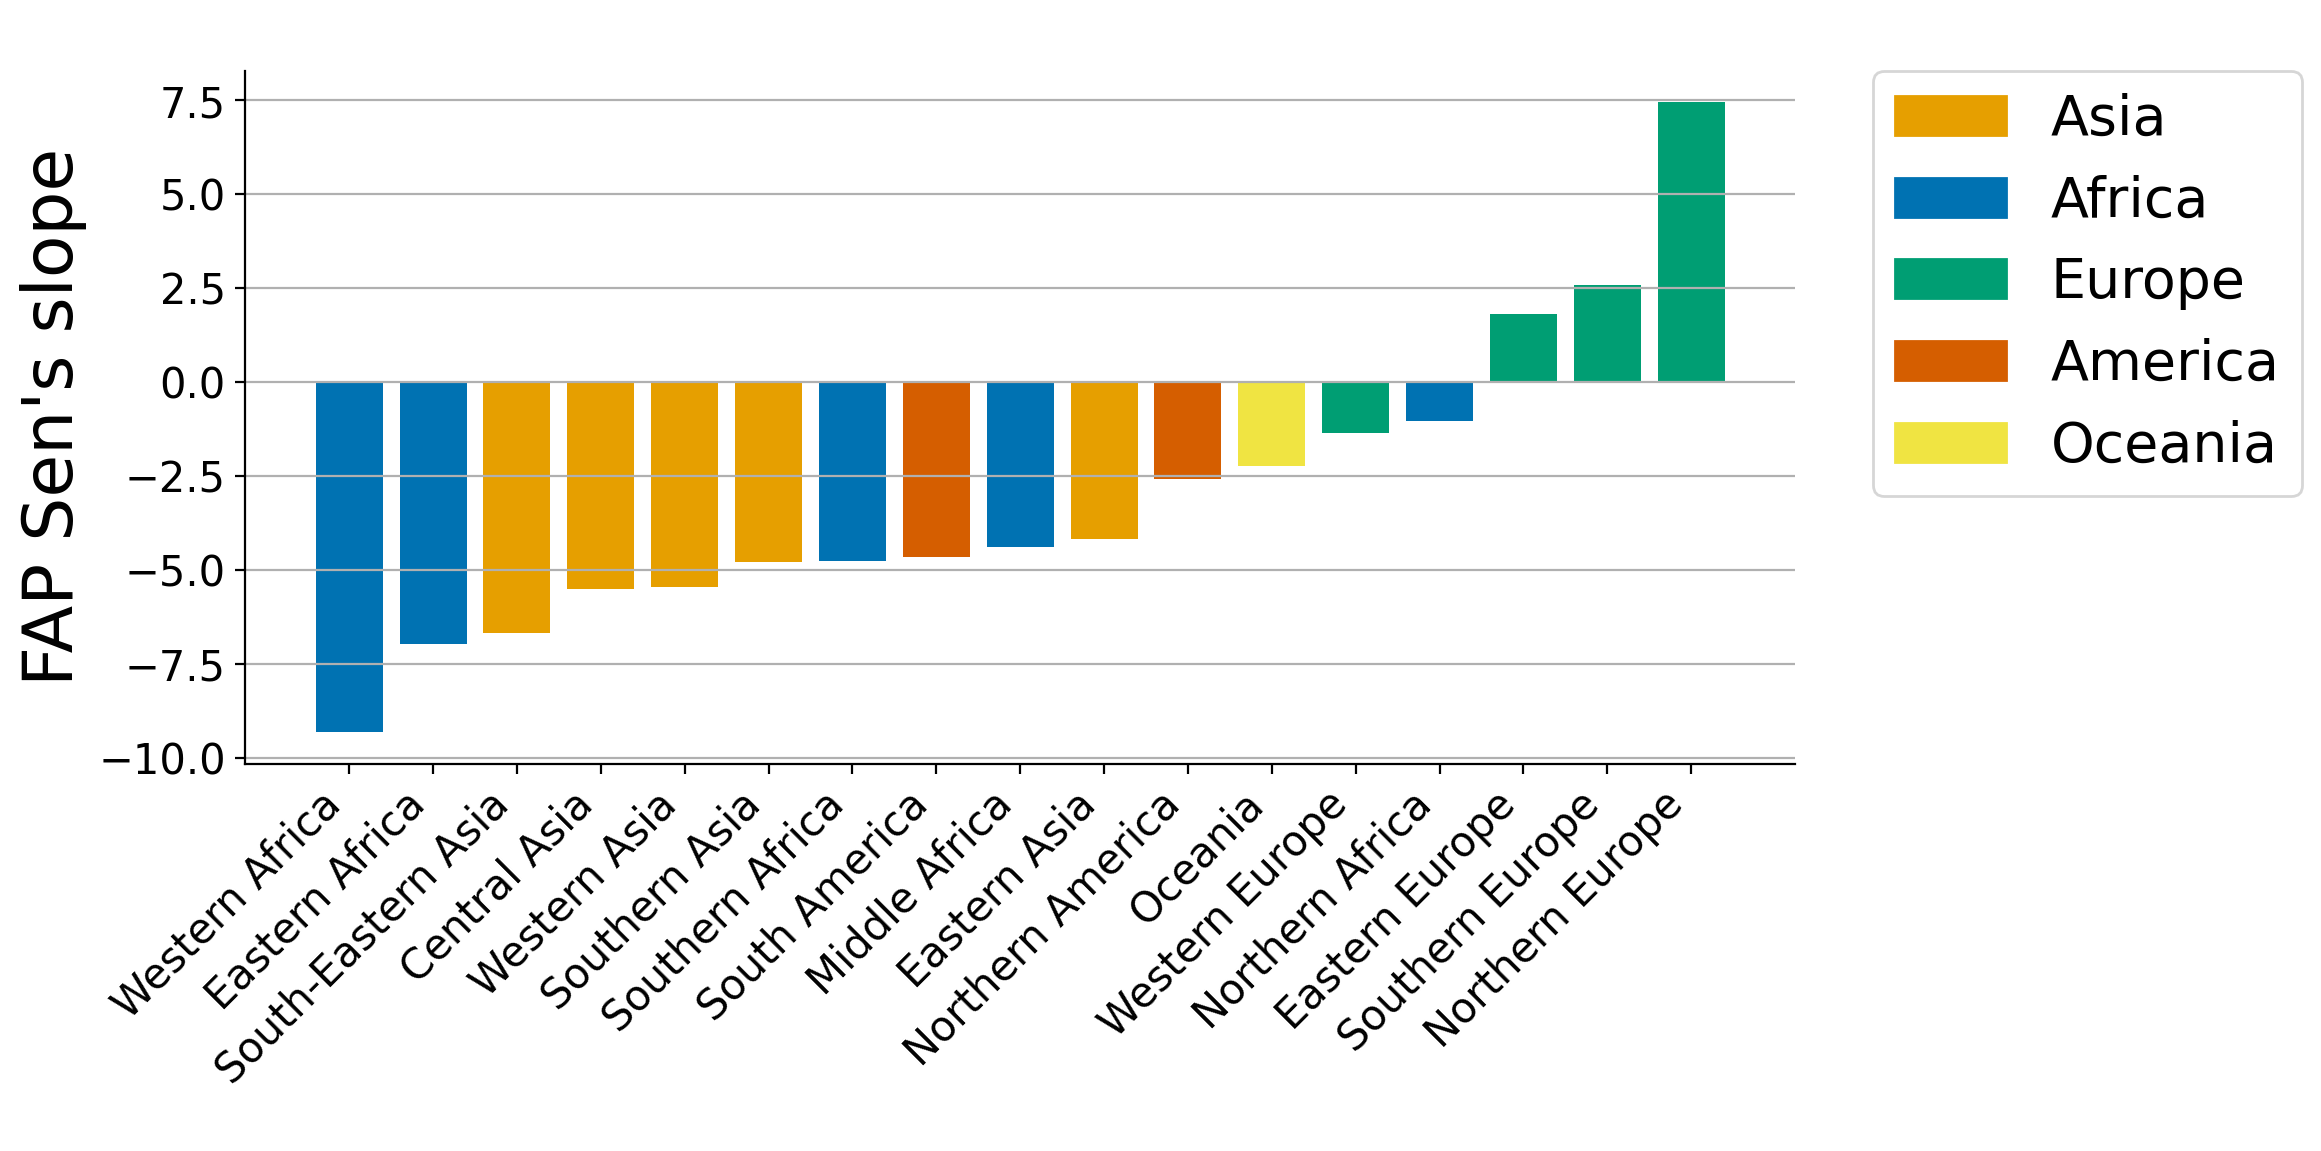

In [95]:
results_df = results_df.sort_values('Slope')
colors = results_df['Region'].map(REGION_TO_CONTINENT).map(CONTINENT_COLORS)

# Plotting the bar plot
f, ax = plt.subplots(figsize=(10, 4.5))
ax = set_font(ax, 15)
plt.bar(results_df['Region'], results_df['Slope'], color=colors)
# Adding labels and title
plt.xlabel(' ')
plt.ylabel('FAP '+"Sen's slope", size=25)
plt.title(' ', size=16)
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Creating legend patches
patches = [mpatches.Patch(color=color, label=continent) for continent, color in CONTINENT_COLORS.items()]
# Adding the legend outside the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20)
plt.xticks(rotation=45, ha='right');

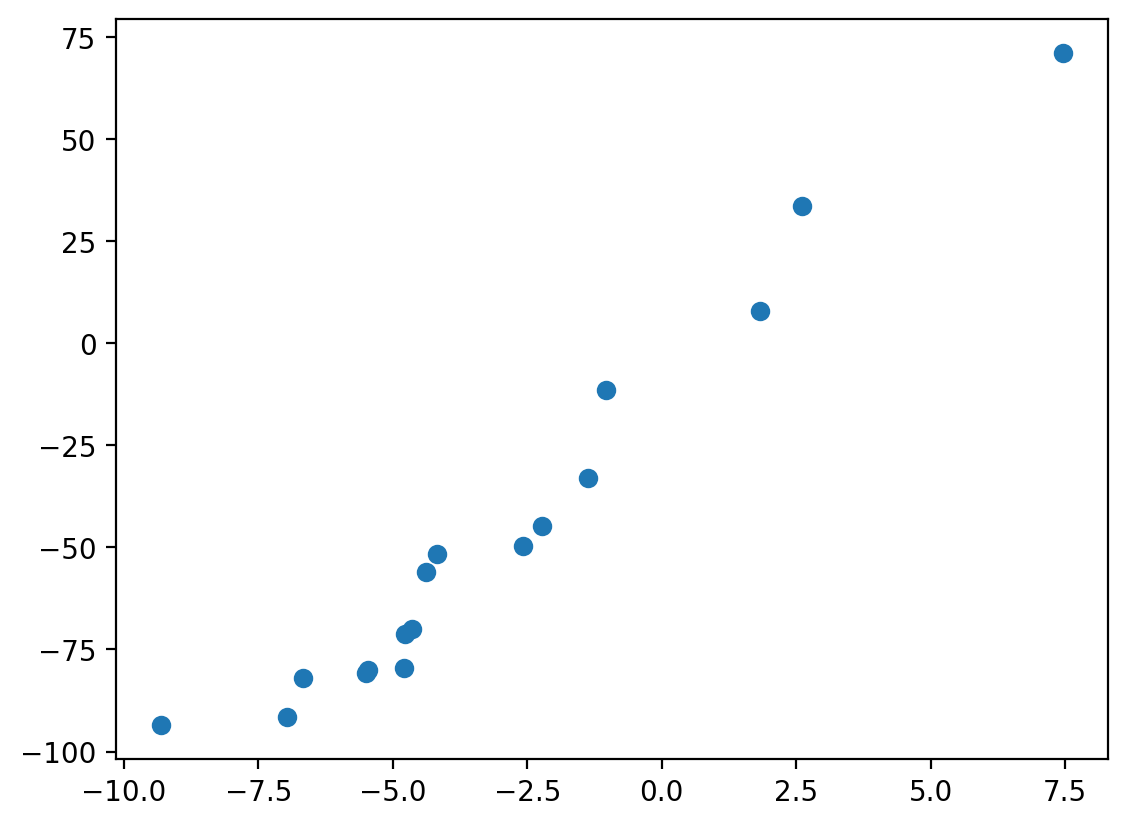

In [96]:
plt.scatter(results_df['Slope'], df5_['relative_change'])